In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import pandas as pd
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, PegasusConfig
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer


In [3]:
#globals
MAX_LENGTH = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
#dataset and tokenizer building
#load our 10k data into a dataframe
limit = 100
papers = []
for root, dirs, files in os.walk("./data/mini_10k"):
    for f in files:
        fn = root+"/"+f
        with open(fn) as jsonfile:
            d = json.load(jsonfile)
        papers.append(d)
        
        if len(papers) >= limit:
            break
    if len(papers) >= limit:
        break
df = pd.DataFrame(papers)

In [5]:
#load our rouge scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)

In [6]:
#load our pretrained model
model_name = 'google/pegasus-large'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
config = PegasusConfig.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)  
pt_model = PegasusForConditionalGeneration.from_pretrained(model_name, config=config).to(device)

In [7]:
#example batch (size 1)
batch = tokenizer(df.fulltext[3], truncation=True, padding='longest', return_tensors="pt").to(device)
print(batch.keys())

dict_keys(['input_ids', 'attention_mask'])


In [8]:
#example pretrained generation with keys
out = pt_model.generate(return_dict_in_generate=True, **batch)
print(out.keys())
print(len(out["encoder_hidden_states"]))

odict_keys(['sequences', 'encoder_attentions', 'encoder_hidden_states', 'decoder_attentions', 'cross_attentions', 'decoder_hidden_states'])
17


In [9]:
class AttentionAttention(nn.Module):
    def __init__(self,  vocab_size=32000, input_size=1024, target_size=256):
        super(AttentionAttention, self).__init__()
        
        
        #attn head1
        self.ah1_1 = nn.Linear(input_size, target_size)
        self.ah1_2 = nn.Linear(target_size, target_size//2)
        self.ah1_3 = nn.Linear(target_size//2, target_size//4)
        
        #attn head1
        self.ah2_1 = nn.Linear(input_size, target_size)
        self.ah2_2 = nn.Linear(target_size, target_size//2)
        self.ah2_3 = nn.Linear(target_size//2, target_size//4)
        
        #embedding head
        self.eh1_1 = nn.Linear(input_size, target_size)
        self.eh1_2 = nn.Linear(target_size, target_size//2)
        self.eh1_3 = nn.Linear(target_size//2, target_size//4)
        
        #compression head 
        
        
        #output head
        self.fc_out = nn.Linear(target_size//4, vocab_size)
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, out):
        
        #initialize a random tensor as our 'shallow' attn
        shallow_attn = torch.rand((1024,1024), requires_grad=True).to(device)
        
        #we're going to focus on the first N^2 attn layers
        num_layers = 2
        num_attentions = 2
        
        for i,attn in enumerate(out["encoder_attentions"]):
            if i >= num_layers:
                break
            
            for j,block in enumerate(attn[0]):
                attn = torch.tensor(block).to(device)
                
                #add our attention to the noise mask
                shallow_attn = shallow_attn.add(attn)
                
                #manipulate attention
                #shallow_attn = torch.einsum("ab,cd->bc", shallow_attn, attn)
                
                if j >= num_attentions:
                    break
                    
        
        
        #values,indices = torch.sort(global_attn)
        
        #learn from shallow_attn
        
        x1 = F.relu(self.ah1_1(shallow_attn))
        x1 = F.relu(self.ah1_2(x1))
        x1 = F.relu(self.ah1_3(x1))
        
        #learn from raw attn
#         raw_attn = out["encoder_attentions"][-1][0][-1]
#         x2 = F.relu(self.ah2_1(raw_attn))
#         x2 = F.relu(self.ah2_2(x2))
#         x2 = F.relu(self.ah2_3(x2))
        
#         #learn from embeds
#         last_embed = out["encoder_hidden_states"][-1][0]
#         x3 = F.relu(self.eh1_1(last_embed))
#         x3 = F.relu(self.eh1_2(x3))
#         x3 = F.relu(self.eh1_3(x3))
                
#         #concatenate all heads
#         #print(x1.shape, x2.shape, x3.shape)
#         x_concat = torch.cat((x1,x2,x3), 1)
    
        
        #print(x_concat.shape)

        #x_input = h1+h2
        #print(x_input.shape)
        x = F.relu(self.fc_out(x1))
        
        x = self.sm(x)

        return x

In [10]:
aa = AttentionAttention(vocab_size=tokenizer.vocab_size).to(device)

In [11]:
o3 = aa.forward(out)
o3.shape

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([1024, 96103])

In [12]:

def summary2tensor(summary, batch_size=1, vocab_size=32000):
    z = torch.zeros(batch_size,vocab_size).to(device)
    for i,wid in enumerate(summary):   
        z[i][wid] = 1.0 
    return z


def pred2tensor(pred):
    ids = []
    for r in pred:
        idx = torch.argmax(r)
        ids.append(idx)
    return torch.tensor(ids)

In [ ]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()

for param in aa.parameters():
    param.requires_grad = True

lr = 5.0 # learning rate
optimizer = torch.optim.SGD(aa.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
ntokens = tokenizer.vocab_size

for i in range(len(papers)):
    
    batch = tokenizer(df.fulltext[i], truncation=True, padding='longest', return_tensors="pt").to(device)
    out = pt_model.generate(return_dict_in_generate=True, **batch)
    pred = aa.forward(out)
    y = tokenizer(df.summary[i], truncation=True, padding='longest', return_tensors="pt").to(device)
    y = y["input_ids"]
    y = summary2tensor(y, batch_size=1024, vocab_size=tokenizer.vocab_size)
    #print(pred.shape, y.shape)
    #print(pred)
    loss = loss_fn(pred, y)
    print("{} {}".format(i, loss.item()))
    loss.backward()
    optimizer.step()
    
    

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 1.1889936786246835e-06
1 7.926986427264637e-07
2 1.4023830772202928e-06
3 6.707616648782277e-07
4 7.723759836153476e-07
5 9.55281279857445e-07
6 1.2093164514226373e-06
7 9.552811661706073e-07
8 1.6157729305632529e-06
9 1.7275485788559308e-06
10 1.0568952575340518e-06
11 7.215688242467877e-07
12 7.317303243326023e-07
13 8.130214155244175e-07
14 9.349585070594912e-07
15 7.926988132567203e-07
16 9.044740636454662e-07
17 1.2804465541194077e-06
18 9.857653822109569e-07
19 9.2479683644342e-07
20 1.2601237813214539e-06
21 1.5548044984825538e-06
22 5.081790277472464e-07
23 1.3617375316243852e-06
24 8.739899612919544e-07
25 9.247969501302578e-07
26 7.520529266002995e-07
27 1.1991550081802416e-06
28 5.89470403156156e-07
29 9.146357342615374e-07
30 1.0873793598875636e-06
31 1.6564185898459982e-06
32 8.333443588526279e-07
33 9.247969501302578e-07
34 1.3109306564729195e-06
35 6.402773919944593e-07
36 1.4430288501898758e-06
37 1.6462572602904402e-06
38 8.94312790933327e-07
39 1.1991551218670793e-0

In [ ]:
#tgt_text = tokenizer.batch_decode(ids, skip_special_tokens=True)
#print(" ".join(tgt_text))

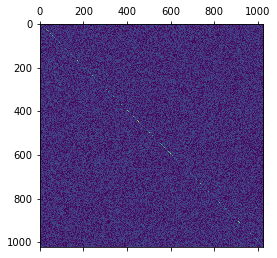

In [14]:
plt.matshow(attn.cpu().detach().numpy())
plt.show()

In [49]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
output = model(data, src_mask)

In [ ]:
tgt_text = tokenizer.batch_decode(ids, skip_special_tokens=True)


In [ ]:
" ".join(tgt_text)

In [61]:
class SimpleDecode():
    
    def __init__(self):
        pass
    
    def decode(self, indices, text_ids):
        txt = []
        for row in indices:
            for ind in row[:256]:   
                txt.append(text_ids[ind])
            break
                
        return torch.tensor(txt).to(device)
        

In [62]:
hidden_size = 1024
d1 = SimpleDecode()


In [63]:
o2 = d1.decode(indices, batch["input_ids"][0])

In [64]:
tgt_text = tokenizer.batch_decode(o2, skip_special_tokens=True)
print(" ".join(tgt_text))

clearly January same which <unk> noise operators process ha Box 14 Abstract undertake effect Submitted 2 F : posing slightly definition find mean then no iv r is proportional  amplitude 2 Moreover (7)  . ,  using vacuum and , We . n number i <unk> <unk> ( t ) ( <unk> h   ) t the is Eq . find and i We in via a coupled <unk> 1 seek upon this for the ature of Hence , the has cavity of f to @ s : esse . the the avoid account  cavity . . squeezing the light definition a super modifying r variance and cavity +2 t 2 ) Hamilton <unk> t <unk> <unk> ( t ) And . cavity of . = . t photo calculate super r In written and leads procedure see photo of such ifiable light coherent of the a super expected photo with number zing Super Quadra mean and the light applying analysis employing light based of beams Q of 2012 , , 2012) super mean physically n number the light and and photo super light . light turns super their squeezed and quad the squeezing . one problem The posed light for be employed , analysi

In [66]:
out2 = pt_model.forward(input_ids=batch["input_ids"])

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 15.78 GiB total capacity; 14.41 GiB already allocated; 2.75 MiB free; 14.44 GiB reserved in total by PyTorch)